<font color=green> <h1> UMD Data Challange 2020 </h1> </font> 
<font color=green> <h3> Ocean Clean Up </h3> </font> <br><br>

##### Authors:
- Maksim Eren
- Nick Solovyev

<p align="center">
  <img width="2000" height="1200" src="cover/pollution.jpg">
</p>
<br>

<p align="center">
  <img src="stats/stat_1.png">
</p>

<p align="center">
  <img src="stats/stat_2.png">
</p>
<br>

<p align="center">
  <img src="stats/stat_3.png">
</p>

<p align="center">
  <img src="stats/stat_4.png">
</p>

<p align="center">
  <img src="stats/stat_5.png">
</p>

<p align="center">
  <img src="stats/stat_6.png">
</p>

<p align="center">
  <img src="stats/stat_7.png">
</p>

<p align="center">
  <img src="stats/trash_type_pie.png">
</p>

### Let's check out some of this data up close 
<br>
<a href="maps/time_lapse.html" target="_blank">Time Lapse</a><br>
<a href="maps/heat_map.html">Heat Map</a><br>
<a href="maps/ocean_debris_combined_map.html">Ocean Debris</a><br>
<a href="maps/sea_turtles_combined_map.html">Sea Turtles</a><br>
<a href="maps/tampa_bay_combined_map.html">Tampa Bay Study</a><br>

## Dataset Corelation Table
<p align="center">
  <img src="plots/corr_table.png">
</p>
<br>



## Pieces of Trash Collected Scatter Plot
<p align="center">
  <img src="plots/items_collected_scatter_plot.png">
</p>

## Miles Covered by State
<p align="center">
  <img width="850" height="300" src="plots/miles_covered_per_state.png">
</p>
<br>

## Pieces of Trash Collected by the Children Volunteers
<p align="center">
  <img src="plots/pieces_per_state.png">
</p>
<br>

## Pounds of Trash Collected by State
<p align="center">
  <img src="plots/pounds_per_state.png">
</p>
<br>

## Types of Trash Frequency
<p align="center">
  <img src="plots/trash_type_frequency.png">
</p>
<br>

<br>

## Clustering Trash Types <br>
### Want to find out:

- What types of trash are commonly found together
- Do any distinct patterns stand out?

### Normal Correlation Matrix, No Clustering
<p align="center">
  <img src="plots/nocluster_trash_corr.png">
</p>

### Single Pass Hierarchical Clustering
<p align="center">
  <img width="800" height="800"  src="plots/single_pass_trash_corr.png">
</p>

### Double Pass Hierarchical Clustering
<p align="center">
  <img width="800" height="800" src="plots/double_pass_trash_corr.png">
</p>

### Machine Learning Fun

In [1]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
import ipywidgets as widgets
import os
import pandas as pd
import numpy as np


MAX_LABELS = 5


#Load the data
DATA_FILE = 'Data_Level5_BAH_OceanCleanup.csv'
if not os.path.exists(DATA_FILE):
    raise Exception('Data file not found. Make sure that the file is located in the same directory as the notebook')

df = pd.read_csv(DATA_FILE, sep=',', header=0, index_col=False)

# Create labels (most frequent trash). Capped by MAX_LABELS
trash_types = df.loc[:, 'Cigarette Butts':'Plastic Pieces']  # isolate trash types
temp_df = df.drop(df.loc[:,'Cigarette Butts':'Plastic Pieces'].head(0).columns, axis=1)  
temp_df['most_freq_trash'] = trash_types.loc[:].idxmax(axis=1)  # find most frequent trash item
all_labels = temp_df['most_freq_trash'].value_counts(sort=True).index.tolist()
limited_types = trash_types.drop(labels=all_labels[MAX_LABELS:], axis=1)  

# Create classifier dataframe
cl_df = df.drop(df.loc[:,'Cigarette Butts':'Plastic Pieces'].head(0).columns, axis=1)
cl_df['most_freq_trash'] = limited_types.loc[:].idxmax(axis=1)  # find most frequent trash item

# Get county and state separately
cl_df['Zone'] = df['Zone'].str.split(',', n = 1, expand=True)
cl_df['State'] = df['State'].str.split(',', n = 1, expand=True)

# Change format of 'date' from mm/dd/yyyy to yyyy and rename to 'year' 
cl_df['Cleanup Date'] = df['Cleanup Date'].str.split('/', n = 2, expand=False)
cl_df['year'] = cl_df['Cleanup Date'].str[2].astype('float')
cl_df = cl_df[cl_df['year'] > 2010]

# Get Seasons
cl_df['month'] = cl_df['Cleanup Date'].str[1].astype('float')
cl_df['season'] = (cl_df['month']%12 + 3)//3

# Get GPS x and y
cl_df['GPS'] = cl_df['GPS'].str.split(',', n=2, expand=False)
cl_df['gps_lat'] = cl_df['GPS'].str[0].astype('float')
cl_df['gps_long'] = cl_df['GPS'].str[1].astype('float')



cl_df.drop(['Cleanup ID', 
            'GPS',
            'Group Name',
            'Cleanup Date',
            'Country',
            'month',
            'Adults',
            'Children',
            'People',
            '# of bags',
            'Pounds',
            'Total Items Collected',
            'Miles',
            'Zone',
            'State',
            'Cleanup Type',
            'year',
            'season'], 
             axis=1,
             inplace=True)


for col in cl_df:
    cl_df.dropna(subset=[col], inplace=True)
    
    
    
    
X = cl_df.drop(columns=['most_freq_trash'])
y = cl_df['most_freq_trash']

cat_df_list = list(X.select_dtypes(include=['object']))
num_df_list = list(X.select_dtypes(include=['float64', 'int64']))




# pipeline for numerical features
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler()),
    
])

# pipeline for categorical features
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('one_hot', OneHotEncoder()),
])

X_pipeline = ColumnTransformer([
    ('cat', cat_pipeline, cat_df_list),
    ('num', num_pipeline, num_df_list),
])


# Split to train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Prep data with pipeline
X_prepared = X_pipeline.fit_transform(X)  # Whole set ran through pipeline for cross-val
X_train_prepared = X_pipeline.transform(X_train)
X_test_prepared = X_pipeline.transform(X_test)

# Prep labels
LE = LabelEncoder()
LE.fit(y)
y_prepared = LE.transform(y)
y_train_prepared = LE.transform(y_train)
y_test_prepared = LE.transform(y_test)




import tensorflow as tf

def build_model():
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      min_delta=0,
                                                      patience=10,
                                                      mode='auto',
                                                      verbose=1)
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(512, input_dim=X_train_prepared.shape[1], activation = 'relu', activity_regularizer=tf.keras.regularizers.l1(0.001)))
    model.add(tf.keras.layers.Dense(256, activation = 'relu', activity_regularizer=tf.keras.regularizers.l1(0.001)))
    model.add(tf.keras.layers.Dense(128, activation = 'relu', activity_regularizer=tf.keras.regularizers.l1(0.001)))
    model.add(tf.keras.layers.Dense(len(trash_types.columns), activation = 'softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'], callbacks=[early_stopping])
    return model

# Train and evaluate on test data
nn = build_model()
nn_history = nn.fit(X_train_prepared, y_train_prepared, epochs=10, verbose=True)

result = nn.evaluate(X_test_prepared, y_test_prepared)
print(result)



BBox = ((cl_df.gps_long.min(), cl_df.gps_long.max(),      
         cl_df.gps_lat.min(), cl_df.gps_lat.max()))

C:\Users\solon\Anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Train on 30241 samples
Epoch 1/10
30241/30241 [==============================] - 4s 127us/sample - loss: 1.5089 - accuracy: 0.3878
Epoch 2/10
30241/30241 [==============================] - 3s 92us/sample - loss: 1.4220 - accuracy: 0.4004
Epoch 3/10
30241/30241 [==============================] - 3s 96us/sample - loss: 1.4039 - accuracy: 0.4114
Epoch 4/10
30241/30241 [==============================] - 3s 105us/sample - loss: 1.3939 - accuracy: 0.4172
Epoch 5/10
30241/30241 [==============================] - 3s 103us/sample - loss: 1.3889 - accuracy: 0.4201
Epoch 6/10
30241/30241 [==============================] - 3s 99us/sample - loss: 1.3848 - accuracy: 0.4213
Epoch 7/10
30241/30241 [==============================] - 3s 104us/sample - loss: 1.3819 - accuracy: 0.4232
Epoch 8/10
30241/30241 [==============================] - 3s 111us/sample - loss: 1.3792 - accuracy: 0.4239
Epoch 9/10
30241/30241 [==============================] - 3s 101us/sample - loss: 1.3768 - accuracy: 0.4246
Epoch 10

[1.378472141512581, 0.4261341]


In [2]:
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings('ignore')

ocean = df.copy()

# drop nan
ocean.dropna(subset=["Cleanup Type"], inplace=True)
ocean.dropna(subset=["Zone"], inplace=True)

# seperate labels and predicators
X_knn = ocean.drop(['Zone', 'Cleanup ID', 'State', 'Country', 'GPS', 'Cleanup Type',
                       'Cleanup Date', 'Group Name'], axis=1) 
y_knn = ocean["Cleanup Type"].copy()

# test set size of 20% of the data and the random seed 42 <3
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X_knn, y_knn, test_size=0.2, random_state=42)

# prepare the data
X_train_knn = num_pipeline.fit_transform(X_train_knn)
X_test_knn = num_pipeline.transform(X_test_knn)

le_knn = LabelEncoder()
y_train_knn = le_knn.fit_transform(y_train_knn)
y_test_knn = le_knn.transform(y_test_knn)


# function to print out classification model report
def classification_report(model_name, test, pred, label="1"):
    print(model_name, ":\n")
    print("Accuracy Score: ", '{:,.4f}'.format(accuracy_score(test, pred)))
    print("     Precision: ", '{:,.4f}'.format(precision_score(test, pred, pos_label=label, average='weighted')))
    print("        Recall: ", '{:,.4f}'.format(recall_score(test, pred, pos_label=label, average='weighted')))
    print("      F1 score: ", '{:,.4f}'.format(f1_score(test, pred, pos_label=label, average='weighted')))
    
    
from sklearn.neighbors import KNeighborsClassifier
knnc = KNeighborsClassifier(weights='distance', n_neighbors=4)
knnc.fit(X_train_knn, y_train_knn)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='distance')

In [3]:
y_knn_pred = knnc.predict(X_test_knn)
classification_report("Test data - KNN classifier report, Clean-up Type", y_test_knn, y_knn_pred)

Test data - KNN classifier report, Clean-up Type :

Accuracy Score:  0.9796
     Precision:  0.9707
        Recall:  0.9796
      F1 score:  0.9727


<IPython.core.display.Javascript object>


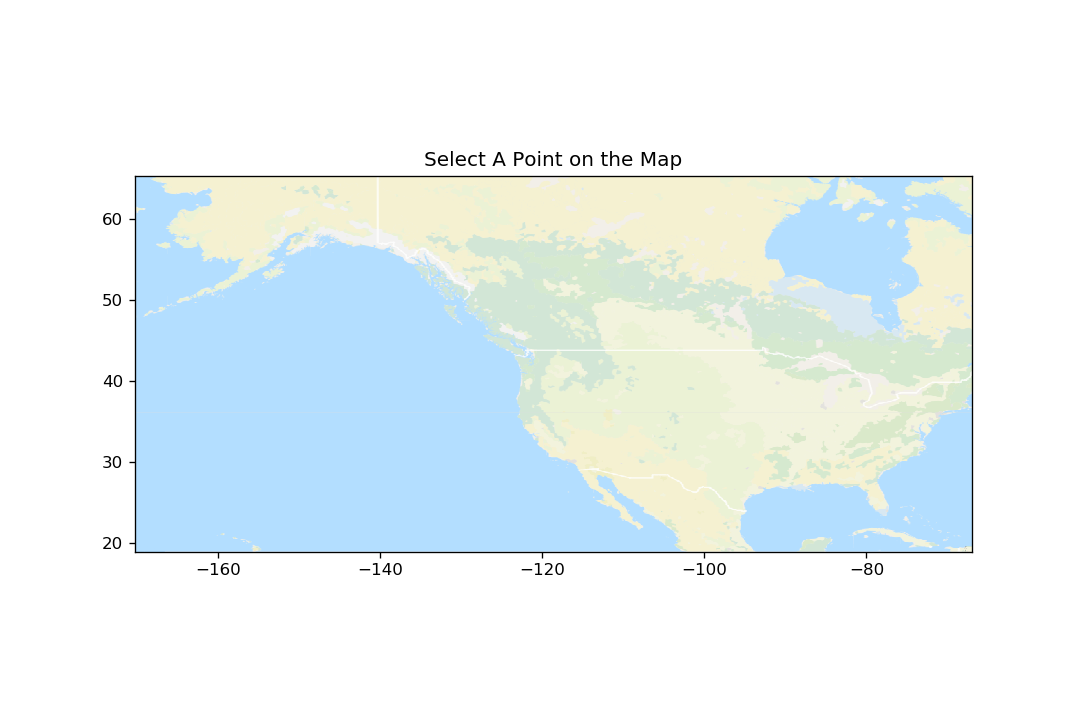

Textarea(value='', placeholder='None Selected')

Button(button_style='success', description='Enter', style=ButtonStyle())

Output()

In [4]:
%matplotlib notebook
import matplotlib.pyplot as plt

the_map = plt.imread('maps/select_map.png')

fig, ax = plt.subplots(figsize = (9,6))
ax.set_title('Select A Point on the Map')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(the_map, zorder=0, extent = BBox, aspect= 'equal')


#Create and display textarea widget
txt = widgets.Textarea(
    value='',
    placeholder='None Selected',
    disabled=False
)
display(txt)

# Define a callback function that will update the textarea
def onclick(event):
    
    full_input = str(event)
    split_1 = full_input.split('xydata=(')
    split_2 = split_1[1].split(') button=1')
    nums = split_2[0].split(',')
    txt.value = 'Lat: ' + nums[0] + ',\n' + 'Long: ' + nums[1]  # update textbox
    
# Create an hard reference to the callback not to be cleared by the garbage collector
ka = fig.canvas.mpl_connect('button_press_event', onclick)


button = widgets.Button(description="Enter", button_style='success')
output = widgets.Output()

display(button, output)

def on_button_clicked(b):
    with output:
        if txt.value == '':
            print('Select point on the map')
        else:
            
            # get lat and long
            lat = txt.value.split(',\n')[0]
            lat = float(lat[4:])
            long = txt.value.split(',\n')[1]
            long = float(long[5:])
            
            cl_in = pd.DataFrame([[lat, long]], columns=num_df_list)
            cl_in_prepared = X_pipeline.transform(cl_in)
            pred = nn.predict(cl_in_prepared)
            pred_output = LE.inverse_transform([pred.argmax()])[0]
            
            print('Most probable trash at Lat: {}, Long: {} will be {}'.format(round(lat, 3), round(long, 3), pred_output))
                  
button.on_click(on_button_clicked)

<p align="center">
  <img src="cover/sea-turtle.jpg">
</p>
<br>